In [7]:
%%capture
!pip install rasterio
!pip install geopyspark
!pip install geopandas
!pip install shapely

In [8]:
import rasterio
from rasterio import mask
from rasterio.features import rasterize
from rasterio.plot import reshape_as_image
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import geopandas as gpd
from shapely.geometry import mapping, Point, Polygon
from shapely.ops import cascaded_union

In [9]:
tile_path = r'/content/drive/MyDrive/Work/QuantumTasks/Quantum internship/T36UXV_20200406T083559_TCI_10m.jp2'


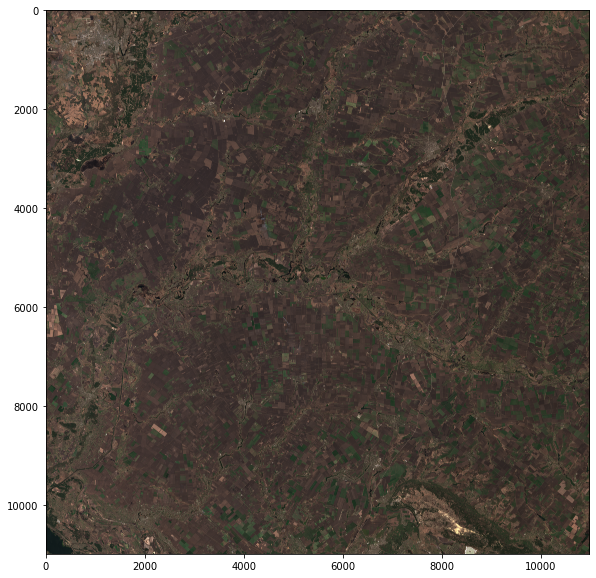

In [11]:
reader = rasterio.open(tile_path)
PIC = reshape_as_image(reader.read())
fig = plt.figure(figsize=(15,10))
plt.imshow(PIC)

In [12]:
train_df = gpd.read_file('/content/drive/MyDrive/Work/QuantumTasks/Quantum internship/masks/Masks_T36UXV_20190427.shp')
train_df = train_df.to_crs({'init' : reader.meta['crs']['init']})

train_df = train_df.loc[~train_df["geometry"].isnull()]
train_df.head()
print(len(train_df))
print(reader.meta['crs']['init'])

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


935
epsg:32636


In [13]:
failed = []
for num, row in train_df.iterrows():
    try:
        masked_image, out_transform = mask.mask(reader, [mapping(row['geometry'])], crop=True, nodata=0)
    except Exception as e:
        # print(e)
        failed.append(num)
print("Rasterio failed to mask {} files".format(len(failed)))
print(failed)

Rasterio failed to mask 435 files
[12, 13, 14, 43, 44, 45, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 352, 354, 355, 356, 357, 358, 394, 395, 450, 451, 452, 453, 495, 496, 497, 498, 499, 500, 501, 502, 503, 504, 505, 506, 507, 508, 509, 510, 511, 512, 513, 514, 515, 560, 561, 562, 563, 564, 565, 566, 567, 568, 569, 570, 571, 572, 573, 574, 575, 576, 577, 578, 579, 580, 581, 582, 583, 584, 585, 586, 587, 588, 589, 590, 5

In [15]:
def poly_from_utm(polygon, transform):
    poly_pts = []
    
    # make a polygon from multipolygon
    poly = cascaded_union(polygon)
    for i in np.array(poly.exterior.coords):
        
        # transfrom polygon to image crs, using raster meta
        poly_pts.append(~transform * tuple(i))
        
    # make a shapely Polygon object
    new_poly = Polygon(poly_pts)
    return new_poly

poly_shp = []
im_size = (reader.meta['height'], reader.meta['width'])
for num, row in train_df.iterrows():
    if row['geometry'].geom_type == 'Polygon':
        poly = poly_from_utm(row['geometry'], reader.meta['transform'])
        poly_shp.append(poly)
    else:
        for p in row['geometry']:
            poly = poly_from_utm(p, src.meta['transform'])
            poly_shp.append(poly)

MASK = rasterize(shapes=poly_shp,out_shape=im_size) 

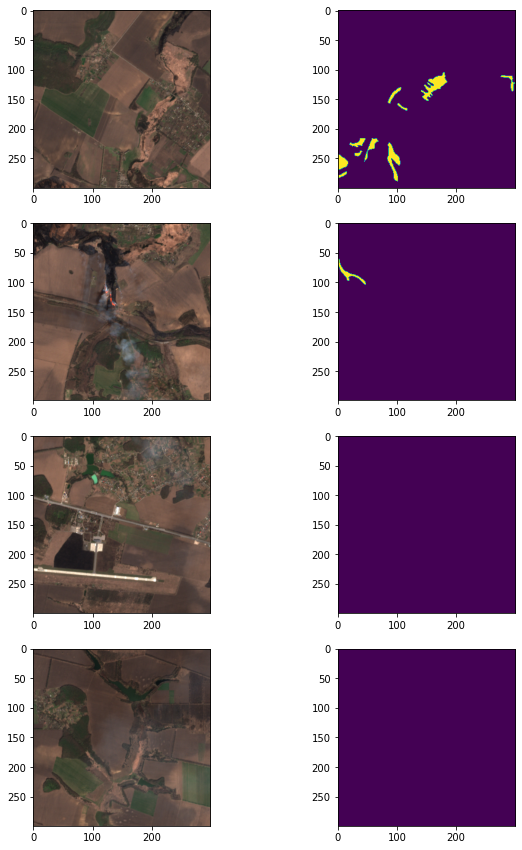

In [18]:
p_size = 300
fig, axes = plt.subplots(4,2,figsize=(10,15))
for i in range(4):
    axes[i,0].imshow(PIC[i*p_size:(i+1)*p_size,:p_size,:])
    axes[i,1].imshow(MASK[i*p_size:(i+1)*p_size,:p_size])

In [22]:
def get_raw_dataset(data, size=(300, 300), margin=(300, 300)):
    img, mask = data
    windows = []
    targets = []
    window = np.array([[0, 0], [size[0], size[1]]])
    shift_right = np.array([[margin[0], 0], [margin[0], 0]])
    new_row = lambda: window * np.array([[0, 1], [0, 1]]) + np.array([[0, margin[1]], [size[0], margin[1]]])
    cut_out = lambda: (img[window[0, 0]:window[1, 0], window[0, 1]:window[1, 1], :],
                       mask[window[0, 0]:window[1, 0], window[0, 1]:window[1, 1]])
    while True:

        if window[1, 0] > img.shape[0]:
            window = new_row()
            continue
        if window[1, 1] > img.shape[1]:
            break

        windows.append(window.copy())
        tar = np.max(mask[window[0, 0]:window[1, 0], window[0, 1]:window[1, 1]])

        targets.append(tar)
        window += shift_right
    return (np.array(windows), np.array(targets))


dataset = get_raw_dataset((PIC, MASK))


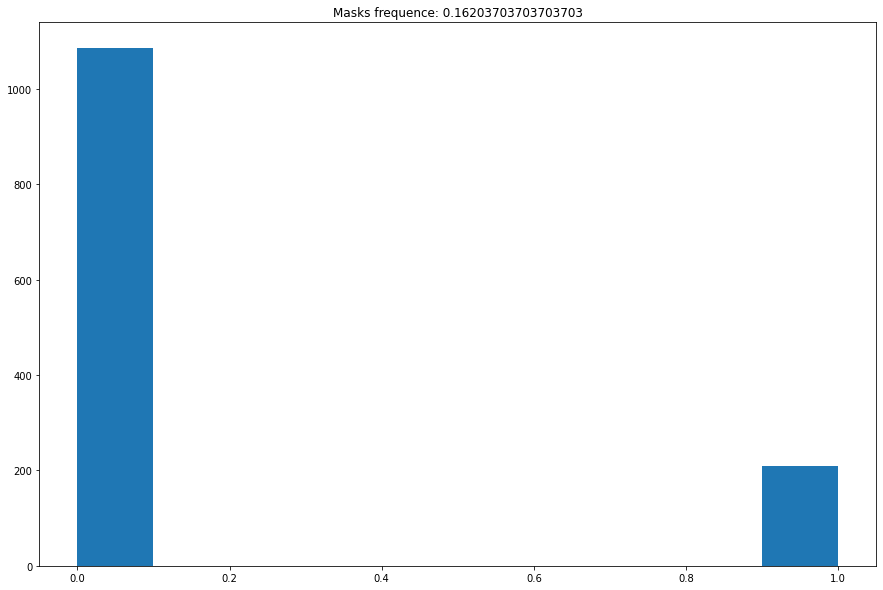

In [29]:
plt.figure(figsize=(15,10))
plt.hist(dataset[1])
plt.title(f"Masks frequence: {np.sum(dataset[1])/len(dataset[1])}")
plt.show()